In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import resnet50
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

In [10]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_new3', 'X_train.npy'))
    labels = np.load(os.path.join('Data_new3', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_new3', 'X_test.npy'))
    labels = np.load(os.path.join('Data_new3', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [12]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [57]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_resnet50(verbose=False, fc_size=256, dropout=None):
    
    from tensorflow.keras.applications import resnet50
    
    resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet50 = models.Sequential()
    resnet50.add(resnet50_base)

    resnet50.add(layers.Flatten())
    if dropout is not None:
        resnet50.add(layers.Dropout(dropout))
    resnet50.add(layers.Dense(fc_size, activation='relu'))
    resnet50.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    resnet50_base.trainable = False
    
    if verbose:
        resnet50_base.summary()
        resnet50.summary()

    return resnet50

In [58]:
resnet50_fe_drop_temp = create_resnet50(verbose=True, dropout=0.5, fc_size=256)

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [30]:
resnet50_base = resnet50.ResNet50(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))

In [39]:
# Instantiate a VGG19 network with custom final layer
resnet50 = models.Sequential()
resnet50.add(resnet50_base)
resnet50.add(layers.Flatten())

resnet50.add(layers.Dropout(0.5))
resnet50.add(layers.Dense(128, activation='relu'))
resnet50.add(layers.Dense(4, activation='softmax'))

resnet50_base.trainable = False

resnet50_fe_drop_128 = resnet50

In [40]:
resnet50_fe_drop_128.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 40,365,572
Trainable params: 16,777,860
Non-trainable params: 23,587,712
_________________________________________________________________


In [41]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet50_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet50_fe_drop_128.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Train
history_resnet50_fe_drop_128 = resnet50_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 23.0123 - accuracy: 0.3227
Epoch 00001: val_loss improved from inf to 1.38391, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 33s 2s/step - loss: 21.5278 - accuracy: 0.3235 - val_loss: 1.3839 - val_accuracy: 0.3540
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3961 - accuracy: 0.3445
Epoch 00002: val_loss improved from 1.38391 to 1.38270, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 29s 2s/step - loss: 1.3955 - accuracy: 0.3436 - val_loss: 1.3827 - val_accuracy: 0.3574
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3942 - accuracy: 0.3463
Epoch 00003: val_loss improved from 1.38270 to 1.38006, saving model to resnet50_f

Epoch 27/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3080 - accuracy: 0.3468
Epoch 00027: val_loss improved from 1.33121 to 1.31826, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.3052 - accuracy: 0.3462 - val_loss: 1.3183 - val_accuracy: 0.3574
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2948 - accuracy: 0.3491
Epoch 00028: val_loss did not improve from 1.31826
19/19 [==============================] - 29s 2s/step - loss: 1.2965 - accuracy: 0.3462 - val_loss: 1.3327 - val_accuracy: 0.3574
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3026 - accuracy: 0.3473
Epoch 00029: val_loss did not improve from 1.31826
19/19 [==============================] - 30s 2s/step - loss: 1.3042 - accuracy: 0.3462 - val_loss: 1.3380 - val_accuracy: 0.3574
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2980 - accuracy: 0.3468
Epoch 00030: val_loss 

Epoch 56/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2434 - accuracy: 0.4308
Epoch 00056: val_loss did not improve from 1.29652
19/19 [==============================] - 29s 2s/step - loss: 1.2387 - accuracy: 0.4350 - val_loss: 1.3109 - val_accuracy: 0.3986
Epoch 57/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2495 - accuracy: 0.4244
Epoch 00057: val_loss improved from 1.29652 to 1.29195, saving model to resnet50_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.2451 - accuracy: 0.4294 - val_loss: 1.2920 - val_accuracy: 0.4124
Epoch 58/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2326 - accuracy: 0.4448
Epoch 00058: val_loss did not improve from 1.29195
19/19 [==============================] - 29s 2s/step - loss: 1.2364 - accuracy: 0.4389 - val_loss: 1.3185 - val_accuracy: 0.3677
Epoch 59/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2428 - accuracy: 0.4384
Epoch 00059: val_loss 

In [43]:
# Save
models.save_model(resnet50_fe_drop_128, 'resnet50_fe_drop_128_4cl_end.h5')

In [46]:
# History of accuracy and loss
tra_loss_fe = history_resnet50_fe_drop_128.history['loss']
tra_acc_fe = history_resnet50_fe_drop_128.history['accuracy']
val_loss_fe = history_resnet50_fe_drop_128.history['val_loss']
val_acc_fe = history_resnet50_fe_drop_128.history['val_accuracy']

In [47]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet50_fe_drop_128 = models.load_model('resnet50_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet50_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [48]:
print("resnet50 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet50 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 91
Epoch [opt]: 61
Valid accuracy [end]: 0.3625
Valid accuracy [opt]: 0.4107
Test accuracy [end]:  0.3939
Test accuracy [opt]:  0.4382
Valid loss [end]: 1.3135
Valid loss [opt]: 1.2864
Test loss [end]:  1.2436
Test loss [opt]:  1.2458


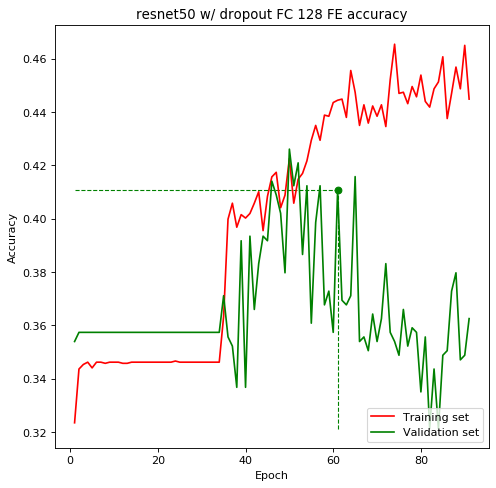

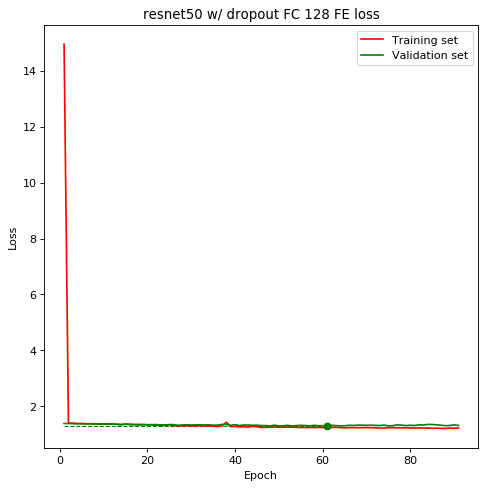

In [49]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet50 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();